# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [1]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

# custom GAlaxy SELection functions
import gasel as gs

from astropy.io import ascii

from lmfit import Model

In [1397]:
np.arange(-18, 90, 4)

array([-18, -14, -10,  -6,  -2,   2,   6,  10,  14,  18,  22,  26,  30,
        34,  38,  42,  46,  50,  54,  58,  62,  66,  70,  74,  78,  82,
        86])

## Load the data & prepare/select

I have prepared my own dataset from data up to 22-05-23 which already includes the BGS Bright selection.

In [129]:
full_table = Table.read("/global/homes/j/jgassert/good_z_data_BGSBright.fits")

In [1275]:
ztile_cat = Table(full_table, copy = True)

In [1276]:
ztile_cat[200000:200002]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39627545292835932,65.0652471976436,-9.90461744495407,20220212,0.340603067748156,4.50495875036377e-05,0,5.3754506111145,26.9688396453857,69.6074981689453,GALAXY,131074,0.0998876020312309,5.65327644348145
39627545292836132,65.0762918909721,-10.0423119480416,20220922,0.150783590305065,5.75640030536749e-05,0,16.0989971160889,47.8101768493652,96.8776168823242,GALAXY,131074,0.0972932130098343,3.54252600669861


In [1277]:
# ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'LASTNIGHT', 'SPECTYPE', 'BGS_TARGET'])

In [1278]:
min_ra = 210
min_dec = 30
max_ra = 270
max_dec = 45

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 711.98 sqdeg


In [1279]:
sky_sel = True # if true, then make a selection

if sky_sel == False:
    area = gs.omega_sky
else:
    ii = ztile_cat['TARGET_RA']>(min_ra)
    ii &= ztile_cat['TARGET_RA']<(max_ra)
    ii &= ztile_cat['TARGET_DEC']>(min_dec)
    ii &= ztile_cat['TARGET_DEC']<(max_dec)

    ztile_cat = ztile_cat[ii]
print(f"All entries after localization selection: {len(ztile_cat)}, with a sky area of {area}")

All entries after localization selection: 458077, with a sky area of 711.9806682317164


In [1280]:
#ztile_cat = ztile_cat[ztile_cat["PROGRAM"] == "bright"]

In [1281]:
#print("All entries in BRIGHT data: ", len(ztile_cat))

In [1282]:
#print("All entries in BGS_TARGET > 0 data: ", len(ztile_cat))

In [1283]:
ztile_cat  = ztile_cat[ztile_cat["Z"]>0.1]
ztile_cat  = ztile_cat[ztile_cat["Z"]<0.2]

In [1284]:
#ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [1285]:
#ztile_cat = ztile_cat[ztile_cat['Z']>=0]
print("All entries after good redshift selection", len(ztile_cat))

All entries after good redshift selection 157625


In [1286]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]
print("All entries after Flux Z selection", len(ztile_cat))

All entries after Flux Z selection 157625


In [1287]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]
print("All entries after Flux R selection", len(ztile_cat))

All entries after Flux R selection 157625


In [1288]:
ztile_cat = ztile_cat[ztile_cat["FLUX_G"] > 0.0]
print("All entries after Flux G selection", len(ztile_cat))

All entries after Flux G selection 157625


In [1289]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [1290]:
print("All entries after Type (Galaxy) selection", len(ztile_cat))

All entries after Type (Galaxy) selection 156981


In [1291]:
ztile_cat[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39628481163690801,210.00297557756,30.0018511912413,20230319,0.147265851065133,7.4364967849403e-06,0,14.7018299102783,23.1497573852539,32.0197525024414,GALAXY,131074,0.0122371269389987,1.73967480659485
39628481163691077,210.019712252076,30.0780974679947,20230319,0.109962347331243,1.29556967505809e-05,0,15.5349826812744,24.8674926757812,38.4654846191406,GALAXY,131074,0.0144533785060048,0.610406935214996
39628481163691092,210.020357945222,30.092709249839,20230402,0.146660718934836,2.35824592679098e-05,0,75.7559432983398,151.81005859375,246.94108581543,GALAXY,131074,0.01477609295398,3.65472197532654
39628481163691220,210.029430444301,30.0055291830532,20230402,0.109417035366972,5.65207288427875e-06,0,9.63973426818848,15.9258823394775,24.8230361938477,GALAXY,131074,0.0120340930297971,0.637734234333038
39628481163691360,210.039013414964,30.113236216447,20230402,0.107746685027154,2.01875890988739e-05,0,16.691349029541,35.3922004699707,59.1554412841797,GALAXY,131074,0.0146014373749495,1.0


### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology and compare them visually

In [1292]:
MW_TRANSMISSION_g = gs.mw_transmission_from_data_table(data = ztile_cat, band = "g")
MW_TRANSMISSION_r = gs.mw_transmission_from_data_table(data = ztile_cat, band = "r")
MW_TRANSMISSION_z = gs.mw_transmission_from_data_table(data = ztile_cat, band = "z")

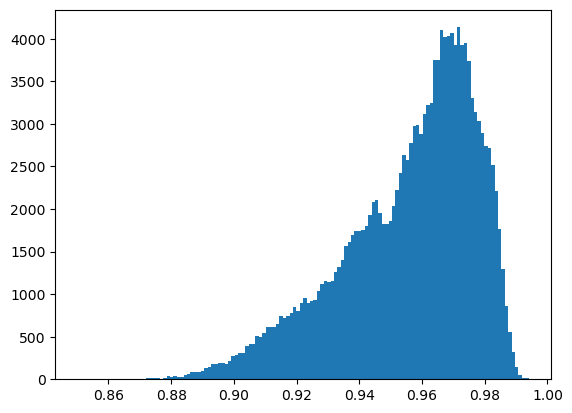

In [1293]:
plt.hist(MW_TRANSMISSION_r, bins = "auto")
plt.show()

In [1294]:
# calculate the apparent magnitude of every galaxy (Planck Cosmology)
app_mag_z = gs.app_mag(ztile_cat["FLUX_Z"])
app_mag_r = gs.app_mag(ztile_cat["FLUX_R"])
app_mag_g = gs.app_mag(ztile_cat["FLUX_G"])

app_mag_z_corr = gs.app_mag(ztile_cat["FLUX_Z"], mw_transmission = MW_TRANSMISSION_z)
app_mag_r_corr = gs.app_mag(ztile_cat["FLUX_R"], MW_TRANSMISSION_r)
app_mag_g_corr = gs.app_mag(ztile_cat["FLUX_G"], MW_TRANSMISSION_g)

In [1295]:
# calculate the absolute magnitude of every galaxy, not yet including a K-correction however with SDSS filters (Planck Cosmology)


### NO K-CORRECTION USED; SHOULD BE ABLE TO IMPLEMENT QUICKLY
abs_mag_z = gs.abs_mag(app_mag_z, ztile_cat["Z"], "z", "g - z", app_mag_g - app_mag_z)
abs_mag_r = gs.abs_mag(app_mag_r, ztile_cat["Z"], "r", "g - r", app_mag_g - app_mag_r)

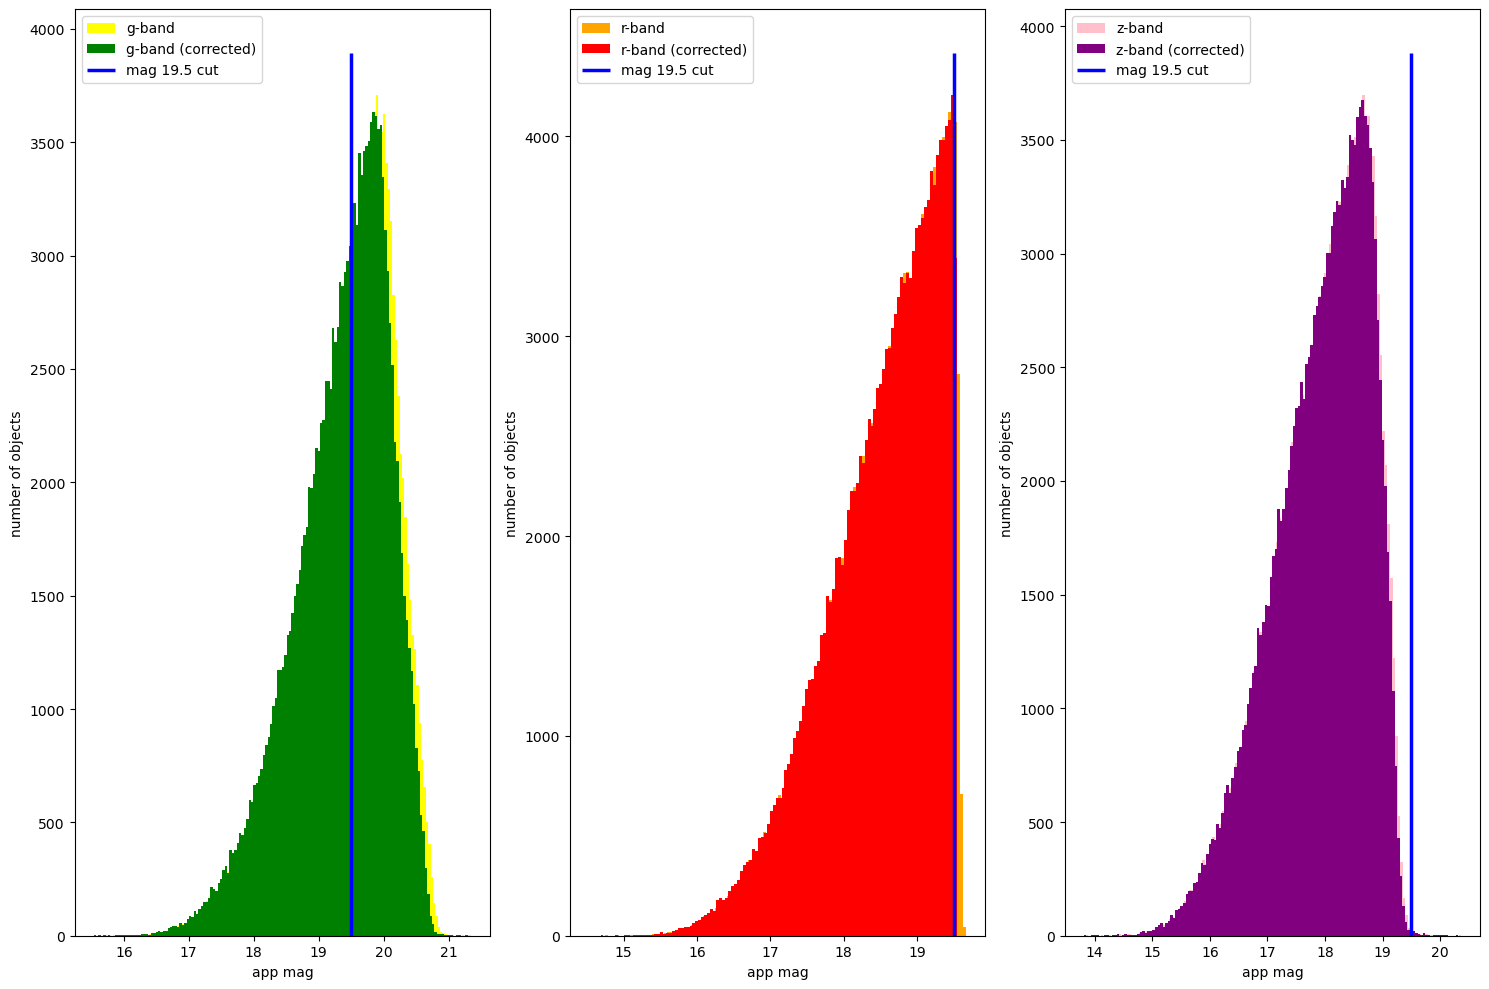

In [1296]:
# plot magnitudes

fig, ax = plt.subplots(ncols = 3, figsize  = (15,10))


ax[0].hist(app_mag_g, bins = "auto", label = "g-band", color = "yellow")
ax[1].hist(app_mag_r, bins = "auto", label = "r-band", color = "orange")
ax[2].hist(app_mag_z, bins = "auto", label = "z-band", color = "pink")

ax[0].hist(app_mag_g_corr, bins = "auto", label = "g-band (corrected)", color = "green")
ax[1].hist(app_mag_r_corr, bins = "auto", label = "r-band (corrected)", color = "red")
ax[2].hist(app_mag_z_corr, bins = "auto", label = "z-band (corrected)", color = "purple")


ymin,ymax = ax[0].get_ylim()
for axis in ax:
    ymin,ymax = axis.get_ylim()
    axis.vlines(19.5, ymin, ymax, color = "blue", linewidth = 2.5, label = "mag 19.5 cut")
    axis.set_xlabel("app mag")
    axis.set_ylabel("number of objects")
    axis.legend(loc = "upper left")

plt.tight_layout()
plt.show()


In [1297]:
np.min(abs_mag_r)

<Quantity -24.18823349>

In [1298]:
app_mag_g = np.copy(app_mag_g_corr)
app_mag_r = np.copy(app_mag_r_corr)
app_mag_z = np.copy(app_mag_z_corr)

### Compare the colors

In [1299]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

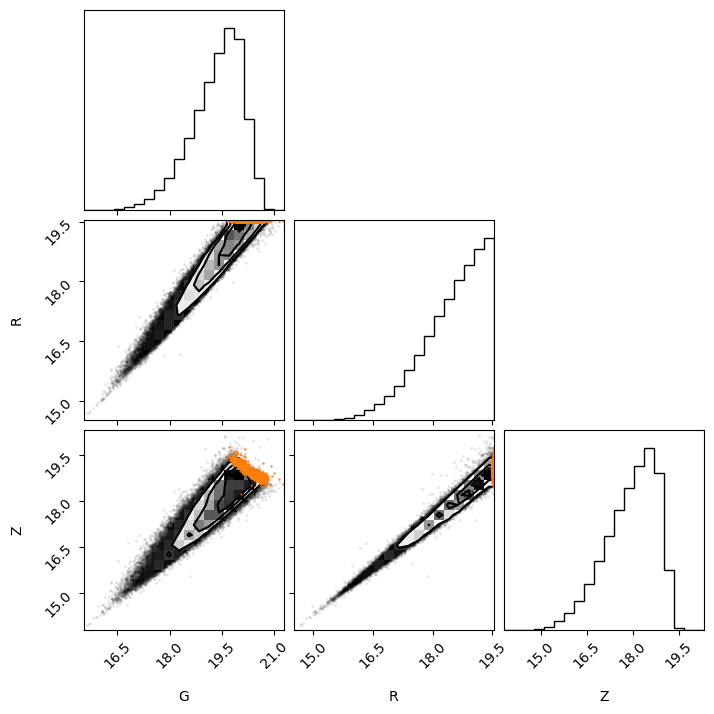

In [1300]:
figure = corner.corner(corner_plot_data, divergences = True)

In [1301]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

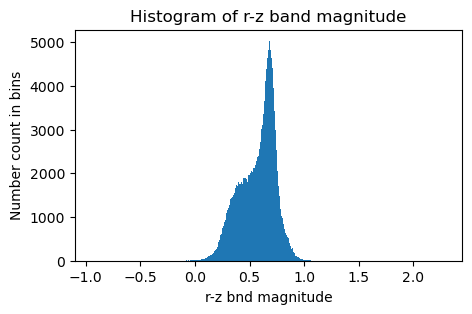

In [1302]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [1303]:
avg_diff = np.mean(diff)

In [1304]:
avg_diff

0.5754248565310724

### Calculate luminosities and add all the data to the table

In [1305]:
lums_z = gs.lum(abs_mag_z, band = "z")

In [1306]:
lums_r = gs.lum(abs_mag_r, band = "r")

In [1307]:
offset = 0

In [1308]:
m_limit_z = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude

In [1309]:
m_limit_z

18.924575143468928

In [1310]:
m_limit_r = 19.5

In [1311]:
lumin_limits_r = gs.lum_lim(lums_r, m_limit_r, app_mag_r)

In [1312]:
lumin_limits_z = gs.lum_lim(lums_z, m_limit_z, app_mag_z)

In [1313]:
# cornerplot (corner, chainconsumer) to see whether I miss peculiar galaxies
# redshift

In [1314]:
ztile_cat = hstack([ztile_cat, Table({"MW_TRANSMISSION_G": MW_TRANSMISSION_g}), Table({"MW_TRANSMISSION_R": MW_TRANSMISSION_r}), Table({"MW_TRANSMISSION_Z": MW_TRANSMISSION_z}), Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({'ABS_MAG_R': abs_mag_r}), Table({'ABS_MAG_Z': abs_mag_z}), Table({"LUM_Z": lums_z}), Table({"LUM_R": lums_r}), Table({'LUM_LIMIT_Z': lumin_limits_z}), Table({'LUM_LIMIT_R': lumin_limits_r})])


In [1315]:
ztile_cat

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628481163690801,210.00297557756,30.0018511912413,20230319,0.147265851065133,7.4364967849403e-06,0,14.7018299102783,23.1497573852539,32.0197525024414,GALAXY,131074,0.0122371269389987,1.73967480659485,0.963945712900877,0.9757730176571993,0.9865771984368094,19.541702955522247,19.062005902099653,18.721782758037392,-20.20484959358109,-20.557028410662753,1.9420167898159606e+36,6.512887854428094e+35,1.611150187322099e+36,4.3508685351816274e+35
39628481163691077,210.019712252076,30.0780974679947,20230319,0.109962347331243,1.29556967505809e-05,0,15.5349826812744,24.8674926757812,38.4654846191406,GALAXY,131074,0.0144533785060048,0.610406935214996,0.9575563863841603,0.9714484940146945,0.984165551965143,19.47463395925085,18.979469451618193,18.51999237817197,-19.596750423028066,-20.070348447274654,1.2404549456234903e+36,3.719922841797233e+35,8.545704843611397e+35,2.303147289201714e+35
39628481163691092,210.020357945222,30.092709249839,20230402,0.146660718934836,2.35824592679098e-05,0,75.7559432983398,151.81005859375,246.94108581543,GALAXY,131074,0.01477609295398,3.65472197532654,0.9566295581343927,0.970820388911554,0.9838148775773772,17.753317713367892,17.01459585200611,16.500800080965163,-22.23697923288923,-22.765211246746215,1.4843151313413314e+37,4.232777654632236e+36,1.5922677162767734e+36,4.2900642520472645e+35
39628481163691220,210.029430444301,30.0055291830532,20230402,0.109417035366972,5.65207288427875e-06,0,9.63973426818848,15.9258823394775,24.8230361938477,GALAXY,131074,0.0120340930297971,0.637734234333038,0.9645331754918182,0.976170154625107,0.9867984280204917,20.000630269469802,19.468555056488096,18.998433871171237,-19.101360376641484,-19.583238870848454,7.920218526861412e+35,2.3570994869510645e+35,8.47775097468872e+35,2.289812574303723e+35
39628481163691360,210.039013414964,30.113236216447,20230402,0.107746685027154,2.01875890988739e-05,0,16.691349029541,35.3922004699707,59.1554412841797,GALAXY,131074,0.0146014373749495,1.0,0.9571310533904093,0.9711602738618433,0.9840046497785025,19.39619992032994,18.59595835916116,18.05250613050862,-19.93259230599579,-20.490310138963657,1.8262728871511106e+36,5.068397698971193e+35,8.179713009593814e+35,2.204215381877211e+35
39628481163691393,210.041301313575,30.102212337463,20230319,0.109321821977478,2.61051475044601e-05,0,43.5662384033203,88.6043014526367,152.781967163086,GALAXY,131074,0.0144699234515429,1.53619384765625,0.9575088478618035,0.9714162824002658,0.9841475705280819,18.354981830157108,17.599876431586623,17.022470317931862,-20.96271310291199,-21.554256331778905,4.8656867822233764e+36,1.3089377826280702e+36,8.439218250852688e+35,2.2744142959853438e+35
39628481163691577,210.053398910827,30.0771069380849,20230319,0.147211719036494,4.1463425910529e-05,0,43.8126792907715,114.859153747559,216.536575317383,GALAXY,131074,0.0138619868084788,5.44828176498413,0.9592571805137158,0.972600585515372,0.9848085062122829,18.350838115629337,17.319422286235042,16.644551318276648,-21.94302635214376,-22.631440481214035,1.31225370772831e+37,3.228823485793542e+36,1.6069718845522204e+36,4.3332447351878156e+35
39628481163691660,210.058162185709,30.0734582377556,20230402,0.105011890216101,1.13827254147843e-05,0,13.4912528991699,21.0608997344971,29.0350761413574,GALAXY,131074,0.0137314992025495,0.731865644454956,0.9596328588141073,0.9728549726539851,0.984950427390739,19.63013206710973,19.161427956307143,18.82622850930289,-19.30929091002733,-19.65790603175247,8.484065812104147e+35,2.8546319791614233e+35,7.749351762851312e+35,2.0898798045598275

In [1316]:
ztile_cat.group_by("ABS_MAG_R")[::-1]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39632936873495453,269.107806176739,32.7822244593572,20210530,0.100159423878067,1.95506133134498e-05,0,7.16245460510254,14.0340614318848,22.8667144775391,GALAXY,514,0.0428123697638512,1.0,0.8794414271345916,0.9177747673921182,0.9538216753980818,20.222862593132866,19.53888185026291,19.050658546071386,-18.758870592105197,-19.288921581556004,6.039628817771656e+35,1.7194201007598173e+35,6.783340375448337e+35,1.782110953855109e+35
39632931643200253,259.783752812673,32.5995622364424,20220420,0.100146099078571,7.86497540028608e-06,0,7.7316951751709,14.1715126037598,24.7687110900879,GALAXY,514,0.0387985073029995,1.0,0.8900979181835968,0.9251875484865989,0.9580589578764612,20.15290765450735,19.537033929687123,18.96872207116231,-18.769144614726052,-19.37536261488589,6.54013423151128e+35,1.735767724072829e+35,6.811541909747141e+35,1.7959952364431976e+35
39632941931824143,267.516657913101,32.9860117481311,20210530,0.101556418538784,4.65815184940562e-05,0,5.81501245498657,13.9431762695312,25.0496425628662,GALAXY,514,0.0470555536448956,4.0,0.868314798136016,0.9100030461999487,0.9493626824550708,20.435316383058108,19.536702820892422,18.946576558094996,-18.78390095755236,-19.420000496260844,6.814622683663271e+35,1.7595197487688687e+35,6.954123199549945e+35,1.8200162854528084e+35
39632977113649425,269.469292609991,34.637227880194,20220516,0.100566767552658,8.63458913444008e-06,0,9.94691848754883,14.2894992828369,20.6446876525879,GALAXY,514,0.041362676769495,1.62315726280212,0.8832754498560639,0.9204451763965048,0.9553498950267756,19.871019001524527,19.522452287898197,19.163385359238088,-18.787853594438243,-19.187331858302148,5.500147791728395e+35,1.7659369773940646e+35,6.853279523472556e+35,1.8028355595675233e+35
39628513149455024,264.994859639047,31.4931361021269,20220510,0.100543440076923,9.7415066998714e-06,0,9.99277305603027,14.5287990570068,19.5818252563477,GALAXY,131074,0.0642926022410393,0.552065551280975,0.8245440853956886,0.8791029127411751,0.9314622699939988,19.7913196410402,19.454525004460912,19.193280243148376,-18.805348083522265,-19.129406717224292,5.214399517445924e+35,1.7946220359086366e+35,6.678613988922178e+35,1.721008430945996e+35
39632936831555079,266.254302921589,32.8714744504489,20220427,0.10221422008194,9.71191635112138e-06,0,10.0582284927368,14.1046380996704,18.706521987915,GALAXY,514,0.0509063005447388,1.0,0.8583391250964396,0.9030070812602548,0.9453341310270353,19.827843529667753,19.5158230215197,19.25898072375226,-18.81136475610244,-19.117942509502086,5.1596307199787034e+35,1.804594648419128e+35,7.02070705258078e+35,1.831086554789939e+35
39633006662517273,269.099229450476,36.1792955468316,20220516,0.100691167614267,2.50584311493338e-06,0,9.92671585083008,14.5763664245605,19.1202754974365,GALAXY,514,0.0468540973961353,1.0,0.8688398666554257,0.9103705364631155,0.9495739126853807,19.855335374402735,19.48892229112631,19.240086573261674,-18.81229744164261,-19.10690961266327,5.107465727818696e+35,1.806145524648032e+35,6.829832188283896e+35,1.787811208793817e+35
39632971484890744,222.481723070837,34.5326648524614,20220417,0.100192144485712,8.11168237756011e-06,0,9.18856239318848,14.7542972564697,20.0613861083984,GALAXY,514,0.0212513115257025,1.62566995620728,0.9382213054264331,0.9583030236634523,0.9768049932840358,20.022644305369653,19.5314608236456,19.218617336024934,-18.813964800871403,-19.14757081985268,5.3023689549861765e+35,1.8089213434400117e+35,6.951632757005726e+35,1.862104340732737e+35


### Cutoff in magnitude and look at distribution

In [1317]:
ztile_cat_r_cut = ztile_cat

In [1318]:
len(ztile_cat_r_cut)

156981

In [1319]:
ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]
# this step should not be necessary if the BGS TARGET selection would actually work

In [1320]:
len(ztile_cat_r_cut)

153657

In [1321]:
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]> 0.1]

In [1322]:
# ztile_cat_r_cut = ztile_cat_r_cut[ztile_cat_r_cut["Z"] > 0.1]

In [1323]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.100001466606648 0.199999718050522


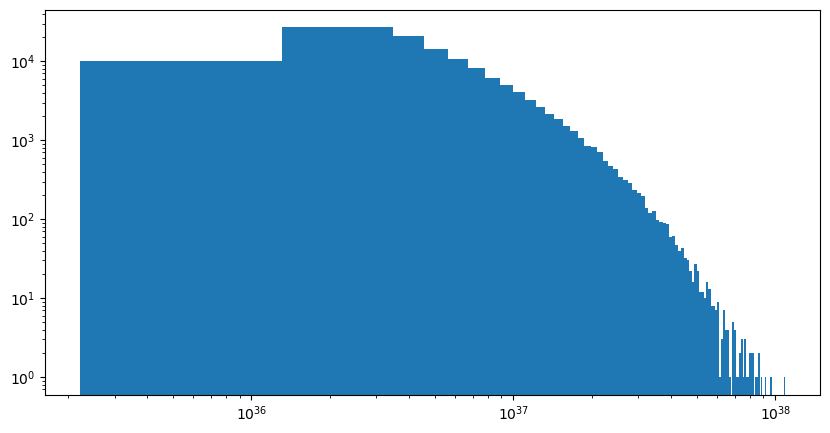

In [1324]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["LUM_Z"], bins = 100)
ax.set_yscale("log")
ax.set_xscale("log")
#ax.vlines(m_limit_z, 0, 4000)

plt.show()

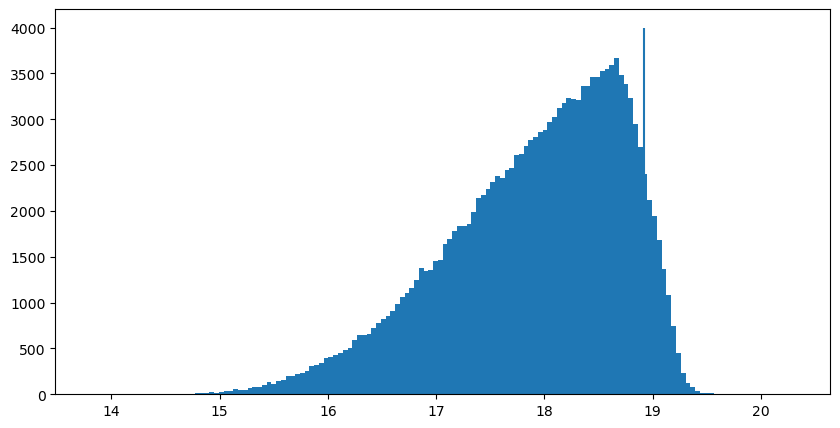

In [1325]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["APP_MAG_Z"], bins = "auto")
ax.vlines(m_limit_z, 0, 4000)

plt.show()

In [1326]:
corner_plot_data = {"G": ztile_cat_r_cut["APP_MAG_G"], "R": ztile_cat_r_cut["APP_MAG_R"], "Z": ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

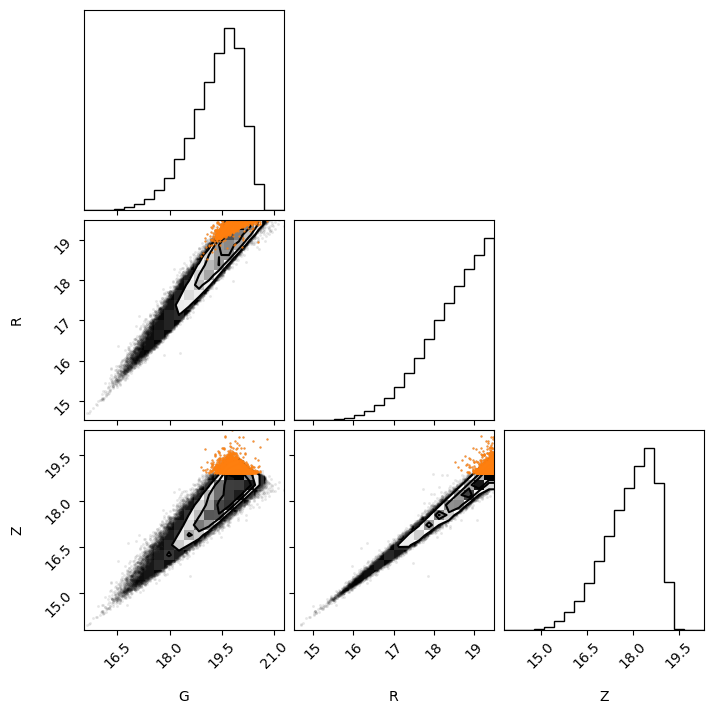

In [1327]:
figure = corner.corner(corner_plot_data, divergences = True)

In [1328]:
corner_plot_data = {"G-R": ztile_cat_r_cut["APP_MAG_G"]-ztile_cat_r_cut["APP_MAG_R"], "R-Z": ztile_cat_r_cut["APP_MAG_R"] - ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

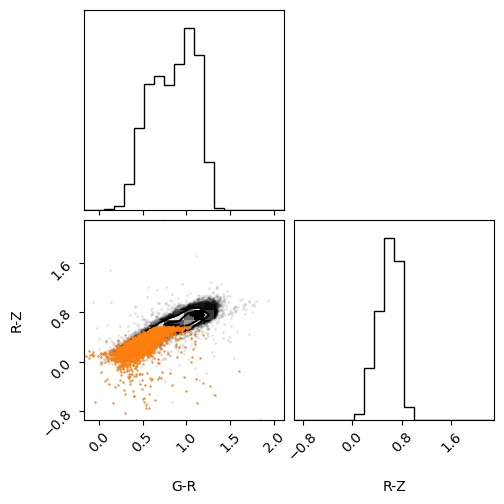

In [1329]:
figure = corner.corner(corner_plot_data, divergences = True)

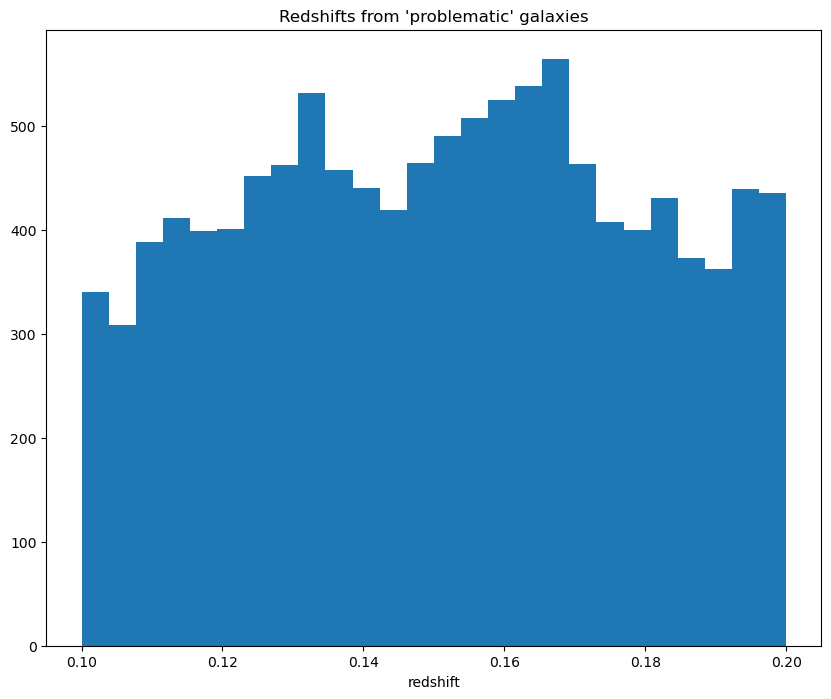

In [1330]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(ztile_cat_r_cut["Z"][ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z], bins = "auto")
ax.set_xlabel("redshift")
plt.title("Redshifts from 'problematic' galaxies")
plt.show()

In [1331]:
len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z]), len(ztile_cat_r_cut), len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z])/len(ztile_cat_r_cut)

(53992, 153657, 0.3513800217367253)

### Get 20% lums of all galaxies and plot

In [1332]:
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

In [1333]:
ztile_cat_grouped_by_AppMag

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628481469876698,231.10032523939,30.0060317803765,20220218,0.117541548034296,3.0193456879753e-05,0,567.128234863281,1479.294921875,2921.36767578125,GALAXY,131074,0.0246070213615894,4.0,0.928821222043855,0.9518796639442276,0.9731918708002536,15.535627150731031,14.521318205500048,13.806530632402676,-24.188233492848724,-24.92706212581637,1.0870924170743059e+38,2.553448833595504e+37,9.75098889729632e+35,2.6040807192153196e+35
39628507831075716,254.146152591578,31.2190333189194,20220611,0.105165498743297,1.56749875574195e-05,0,507.125701904297,1238.060546875,2527.06591796875,GALAXY,131074,0.0322299152612686,3.40961122512817,0.9078162960733455,0.9374477731191605,0.9650338177883058,15.632205881547264,14.698012993871213,13.954814905238134,-23.735846691485484,-24.510533407328822,7.407215484601916e+37,1.6833423097276816e+37,7.616419980716354e+35,2.0201221790843792e+35
39628523106733547,241.70556904543,32.04616600651,20220416,0.115561759225863,1.75658549150001e-05,0,479.943237304688,1233.1513671875,2401.76416015625,GALAXY,131074,0.0321275927126408,4.09121561050415,0.9080950768081291,0.9376400369242884,0.9651428696996592,15.692353611498401,14.702549386355356,14.010153116675445,-23.950970182503823,-24.674755110263984,8.616753319687158e+37,2.052210170931833e+37,9.323411428613269e+35,2.47309950328681e+35
39628502781135246,263.121122807095,31.0367552694681,20220427,0.102572882047058,2.53363813392021e-05,0,448.205017089844,1147.70251464844,2288.72998046875,GALAXY,131074,0.0518155917525291,4.48660135269165,0.8560003077755843,0.9013629629902106,0.9443853518089964,15.702493018057263,14.73767593936292,14.03888670911218,-23.59565348674176,-24.345066550134717,6.360162854803751e+37,1.4794325080891908e+37,7.066312868146552e+35,1.8414737529870773e+35
39632941931824385,267.526684240019,33.0031337734005,20220507,0.101605288969282,2.94300640640392e-05,0,421.258026123047,1075.7470703125,1990.84045410156,GALAXY,514,0.0468755662441254,4.0,0.8687838958892118,0.910331366590204,0.9495514000036936,15.785908934022697,14.818723337854163,14.196205053387585,-23.503386913405652,-24.17170262609274,5.421540001766458e+37,1.3589032209789266e+37,6.962651056997527e+35,1.8225433339842196e+35
39632971543610587,226.685347747288,34.4730937031111,20220218,0.111091297107093,2.5511777158556e-05,0,409.845245361328,1065.51733398438,1991.26159667969,GALAXY,514,0.014938342384994,2.74322962760925,0.9561639205573685,0.9705047532733689,0.9836386180811252,15.91978112756927,14.898592868793243,14.234268132344639,-23.700351389988896,-24.379270886947637,6.563718858886817e+37,1.629199689613586e+37,8.730259769679828e+35,2.3518600022696888e+35
39628491750115211,219.170130966112,30.596034990603,20230509,0.101560750242201,4.89468633745732e-05,0,427.949096679688,1046.24084472656,1976.14050292969,GALAXY,131074,0.013149181380868,4.13373374938965,0.9613111659671353,0.9739910194083987,0.9855840183405554,15.878679682062396,14.922308204653355,14.244689582669398,-23.472174674090382,-24.162640046283446,5.376475047414905e+37,1.3203942740213383e+37,7.22010328420161e+35,1.9481702819120487e+35
39633040225339864,253.882002513839,38.0619977577891,20210709,0.11765623890259,3.1984677076959e-05,0,399.406616210938,981.364501953125,1426.75817871094,GALAXY,514,0.0164773371070623,5.08792209625244,0.9517584346167511,0.96751593320977,0.9819683023709785,15.942778698889624,14.984569453026452,14.594367745892729,-23.744951083992383,-24.151251149479705,5.320372938876047e+37,1.697517250171904e+37,9.859595928422136e+35,2.6524180671873405e+35


In [1334]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [1335]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.822031919794472e+36,7.602540865631926e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379479703740788e+36,3.626273671162997e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285194656747404e+36,3.45702206098581e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990236614920253e+36,3.401096565649251e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048667866712361e+36,8.21393239432351e+35


In [1336]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_AppMag))]

In [1337]:
np.max(ztile_cat_grouped_by_AppMag["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag["LUM_R"]), np.max(ztile_cat_grouped_by_AppMag_sel["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag_sel["LUM_R"])

(2.553448833595504e+37,
 1.7946220359086366e+35,
 1.1522323118689547e+36,
 1.7946220359086366e+35)

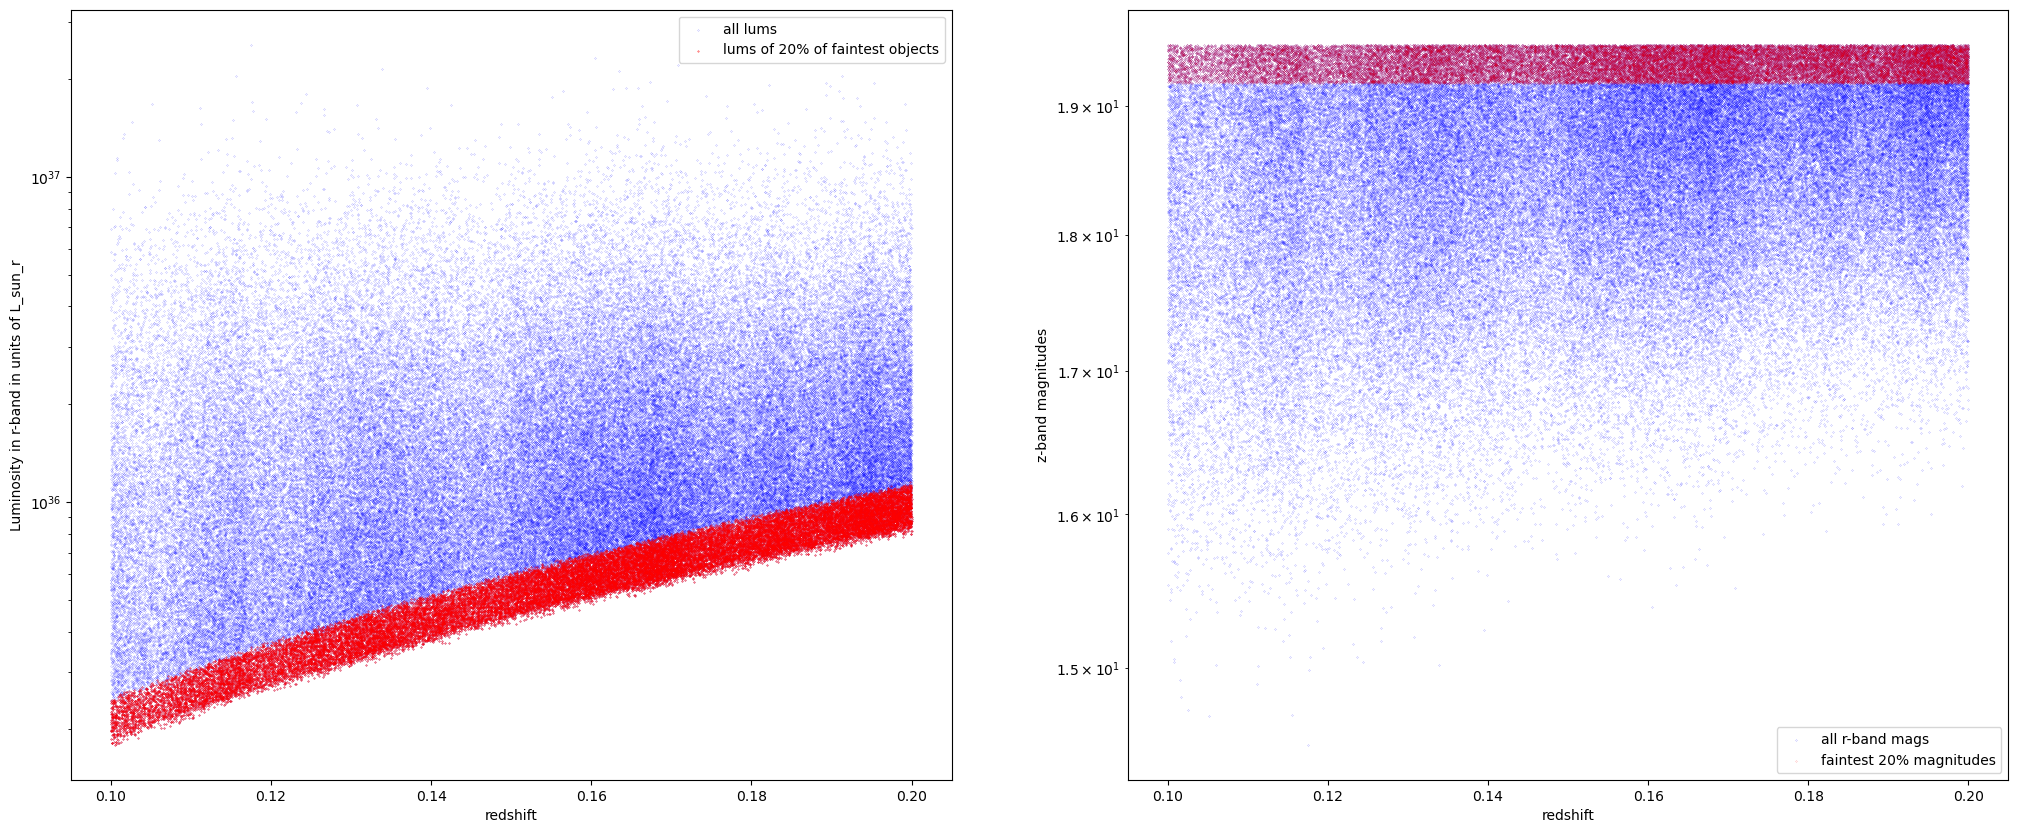

In [1338]:
fig, ax = plt.subplots(ncols = 2, figsize = (25,10))

ax[0].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"], s = 0.01, color = "blue", label = "all lums")
ax[0].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"], s = 0.1, color = "red", label ="lums of 20% of faintest objects")

ax[1].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["APP_MAG_R"], s = 0.01, color = "blue", label = "all r-band mags")
ax[1].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["APP_MAG_R"], s = 0.01, color = "red", label = "faintest 20% magnitudes")


ax[0].set_xlabel("redshift")
ax[0].set_ylabel("Luminosity in r-band in units of L_sun_r")
ax[0].set_yscale("log")
#ax.set_xlim(0.08,.6)
#ax.set_ylim(10**3,10**5)
ax[0].legend()

ax[1].set_xlabel("redshift")
ax[1].set_ylabel("z-band magnitudes")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

In [1339]:
ztile_cat_grouped_by_AppMag_sel

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.822031919794472e+36,7.602540865631926e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379479703740788e+36,3.626273671162997e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285194656747404e+36,3.45702206098581e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990236614920253e+36,3.401096565649251e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048667866712361e+36,8.21393239432351e+35
39633096122828999,243.606491187989,41.0201731749984,20230407,0.138279626857195,6.60093458752409e-06,0,9.84133625030518,15.5370311737061,21.5276794433594,GALAXY,514,0.00994677282869816,1.0,0.9705934711742449,0.9802623644257126,0.9890756901495632,19.984958237473073,19.499935729543107,19.155580774459676,-19.623019042780435,-19.9770919949175,1.1383568205758087e+36,3.811021332620024e+35,1.408252939422713e+36,3.8107957448282435e+35
39633021174809872,265.700910976159,36.969156700567,20220522,0.173815876395162,1.4096968998993e-05,0,7.55792856216431,14.9376420974731,23.9784870147705,GALAXY,514,0.0295792277902365,1.0,0.915065855137738,0.9424411491013431,0.9678628097339647,20.207623919279396,19.49993047625399,19.014980064171144,-20.124190275000437,-20.638039592634346,2.092461389694785e+36,6.046580966898279e+35,2.2741516472489068e+36,6.0461937941223004e+35
39633025922764648,260.111165559501,37.2444580191916,20230407,0.134988139827934,1.25349726807455e-05,0,8.86761474609375,14.2990570068359,20.3584156036377,GALAXY,514,0.0513797178864479,0.764231622219086,0.8571206367235538,0.9021507064691104,0.9448400355898456,19.963087836851592,19.49992923990724,19.16653577836692,-19.476060089622905,-19.859651535538283,1.021650213877953e+36,3.3285707963904585e+35,1.2766930206547516e+36,3.328353872332464e+35


In [1340]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.0005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [1341]:
lower_limit_z, upper_limit_z, num_of_bins_z

(0.100001466606648, 0.199999718050522, 200)

In [1342]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin

cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    
    # z-range selection
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]

    # select only r-band luminosity (limit)
    LUM = dat["LUM_R"]
    LUM_LIM = dat["LUM_LIMIT_R"]
    
    # sort this data ascending
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    # if there was no data in this bin, just store a 0
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity (limit) value for the whole redshift range
    LUM_95[cnt] = LUM[LUM_cut] # this is the 95% lum per bin
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the "Luminosity Limit" value per bin
    cnt += 1

In [1343]:
stop_at = np.argmin(LUM_LIM_95[1:])
if stop_at == 0:
    stop_at = len(LUM_LIM_95)

In [1344]:
stop_at

199

Fit values:  5021014667.158354 -267924496.57785243 11890842.553930212


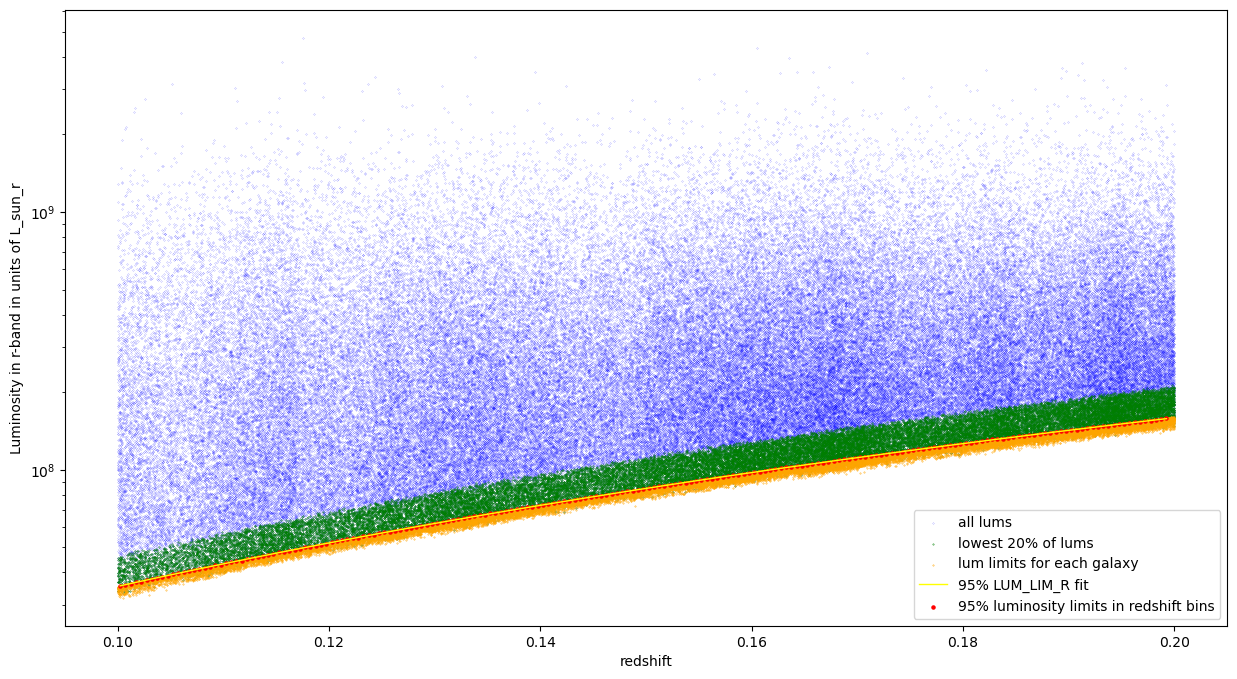

In [1345]:
fig, ax = plt.subplots(figsize = (15,8))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, s = 0.01, color = "blue", label = "all lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/gs.L_sun_r, s = 0.1, color = "green", label ="lowest 20% of lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_LIMIT_R"]/gs.L_sun_r, s = 0.1, color = "orange", label ="lum limits for each galaxy")


center_z = (bins[:-1] + bins[1:])/2
#ax.scatter(center_z, LUM_95/gs.L_sun_r, s = 1, color = "orange", label = "95% cut of luminosities in redshift bin")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

# for the fit to be good, we need to decrease the LUM values, otherwise, they fit doesn't work that well
# normalize_LUM = 10**(7)

coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z, np.array(LUM_LIM_95)/gs.L_sun_r, p0 = [7251562630.908631, -993318577.5495119, 58433580.69203088])
print("Fit values: ", coefs_LUM_LIM_95[0], coefs_LUM_LIM_95[1], coefs_LUM_LIM_95[2])

ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 1, color = "yellow", label = "95% LUM_LIM_R fit")
#ax.plot(center_z, poly2d(center_z, *[7251562630.908631, -993318577.5495119, 58433580.69203088]), linewidth = 1, linestyle = "dashed", color = "purple", label = "old 95% LUM LIM fit")

ax.scatter(center_z, LUM_LIM_95/gs.L_sun_r, s = 5, color = "red", label ="95% luminosity limits in redshift bins")

ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
#ax.set_xlim(0.095, 0.6)
#ax.set_ylim(3*10**7,1*10**9)
ax.legend(loc = "lower right")
plt.show()

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

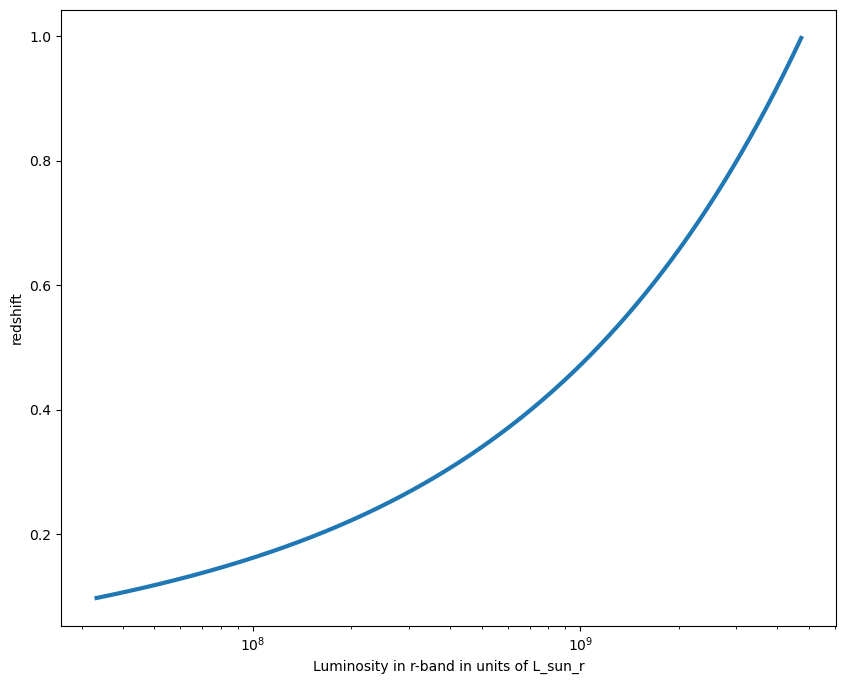

In [1346]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly2d_inverse(x, a,h,k):
    return np.sqrt((x-k)/a)+h

a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (10,8))

#ax.scatter(LUM_LIM_95, center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

lum_bins_plot = np.logspace(np.log10(np.min(ztile_cat_grouped_by_AppMag["LUM_R"])), np.log10(np.max(ztile_cat_grouped_by_AppMag["LUM_R"])), 1000, endpoint = True)

ax.plot(lum_bins_plot/gs.L_sun_r, poly2d_inverse(lum_bins_plot/gs.L_sun_r, *inverted_coefs_95), linewidth = 3)
#ax.vlines(LUM_LIM_95[stop_at-1], 0, 1, label = "limit of fit")


ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
#ax.set_ylim(0,1)
#ax.set_xlim(10,10**5)
#ax.legend()
plt.show()

In [1347]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.822031919794472e+36,7.602540865631926e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379479703740788e+36,3.626273671162997e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285194656747404e+36,3.45702206098581e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990236614920253e+36,3.401096565649251e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048667866712361e+36,8.21393239432351e+35


In [1348]:
np.max(ztile_cat_grouped_by_AppMag["ABS_MAG_R"]), np.min(ztile_cat_grouped_by_AppMag["ABS_MAG_R"])

(-18.805348083522265, -24.188233492848724)

In [1349]:
z_max_i = np.array(poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, *inverted_coefs_95))

In [1350]:
np.min(z_max_i), np.mean(z_max_i), np.max(z_max_i), np.median(z_max_i)

(0.09718629739763462,
 0.24383069993542056,
 0.9968980094712159,
 0.22210984335959413)

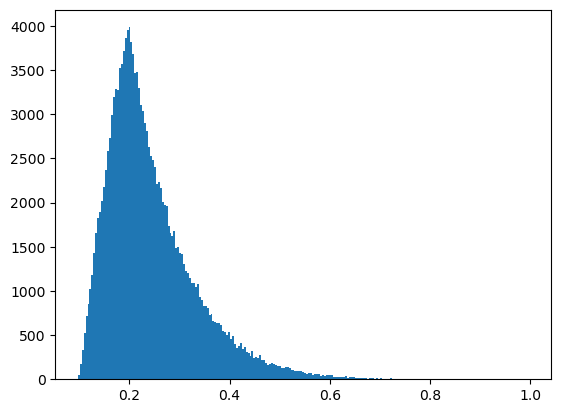

In [1351]:
plt.hist(z_max_i, bins = "auto")
plt.show()

In [1352]:
z_max_i[:5], len(ztile_cat_grouped_by_AppMag)

(array([0.18922113, 0.13501026, 0.13208731, 0.13110366, 0.19602929]), 153657)

In [1353]:
ztile_cat_z_max = 5

In [1354]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"z_max": z_max_i})])

In [1355]:
ztile_cat_z_max[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.822031919794472e+36,7.602540865631926e+35,0.18922112712576633
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379479703740788e+36,3.626273671162997e+35,0.13501026332871724
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285194656747404e+36,3.45702206098581e+35,0.13208731338923013
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990236614920253e+36,3.401096565649251e+35,0.13110365849483824
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048667866712361e+36,8.21393239432351e+35,0.19602929108743689


In [1356]:
#only allow redshifts above 0.1
#ztile_cat_z_max = ztile_cat_z_max[ztile_cat_z_max["z_max"] > 0.1]

In [1357]:
ztile_cat_z_max[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.822031919794472e+36,7.602540865631926e+35,0.18922112712576633
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379479703740788e+36,3.626273671162997e+35,0.13501026332871724
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285194656747404e+36,3.45702206098581e+35,0.13208731338923013
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990236614920253e+36,3.401096565649251e+35,0.13110365849483824
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048667866712361e+36,8.21393239432351e+35,0.19602929108743689


In [1358]:
np.min(ztile_cat_z_max["Z"]), np.max(ztile_cat_z_max["Z"])

(0.100001466606648, 0.199999718050522)

In [1359]:
 z_min_data, z_max_data

(0.100001466606648, 0.199999718050522)

In [1360]:
V_max_i = gs.V_max(area, z_min_data, z_max_data, ztile_cat_z_max["z_max"])

In [1361]:
len(V_max_i)

153657

In [1362]:
len(ztile_cat_z_max)

153657

In [1363]:
V_max_i[:5]

<Quantity [31208155.68208579,  8176792.78925743,  7314141.13230607,
            7031706.46770589, 35138592.89429484] Mpc3>

In [1364]:
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX": V_max_i})])

In [1365]:
ztile_wVmax

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,V_MAX
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc3
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.822031919794472e+36,7.602540865631926e+35,0.18922112712576633,31208155.682085786
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379479703740788e+36,3.626273671162997e+35,0.13501026332871724,8176792.789257428
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285194656747404e+36,3.45702206098581e+35,0.13208731338923013,7314141.132306068
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990236614920253e+36,3.401096565649251e+35,0.13110365849483824,7031706.4677058915
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048667866712361e+36,8.21393239432351e+35,0.19602929108743689,35138592.89429484
39633096122828999,243.606491187989,41.0201731749984,20230407,0.138279626857195,6.60093458752409e-06,0,9.84133625030518,15.5370311737061,21.5276794433594,GALAXY,514,0.00994677282869816,1.0,0.9705934711742449,0.9802623644257126,0.9890756901495632,19.984958237473073,19.499935729543107,19.155580774459676,-19.623019042780435,-19.9770919949175,1.1383568205758087e+36,3.811021332620024e+35,1.408252939422713e+36,3.8107957448282435e+35,0.1381145013519534,9131802.234590966
39633021174809872,265.700910976159,36.969156700567,20220522,0.173815876395162,1.4096968998993e-05,0,7.55792856216431,14.9376420974731,23.9784870147705,GALAXY,514,0.0295792277902365,1.0,0.915065855137738,0.9424411491013431,0.9678628097339647,20.207623919279396,19.49993047625399,19.014980064171144,-20.124190275000437,-20.638039592634346,2.092461389694785e+36,6.046580966898279e+35,2.2741516472489068e+36,6.0461937941223004e+35,0.17046283433324222,21635282.969210252
39633025922764648,260.111165559501,37.2444580191916,20230407,0.134988139827934,1.25349726807455e-05,0,8.86761474609375,14.2990570068359,20.3584156036377,GALAXY,514,0.0513797178864479,0.764231622219086,0.857120

In [1366]:
lower_limit_lum = np.min(ztile_wVmax["LUM_R"])
upper_limit_lum = np.max(ztile_wVmax["LUM_R"])
print("lower and upper limit of LUM_R: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 100

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_R:  1.7946220359086366e+35 2.553448833595504e+37
num of bins 100
[1.79462204e+35 1.88678332e+35 1.98367747e+35 2.08554753e+35
 2.19264904e+35 2.30525066e+35 2.42363485e+35 2.54809854e+35
 2.67895397e+35 2.81652937e+35]


In [1367]:
len(lum_bins)

100

In [1368]:
def calc_phi_j(V_max_i, lum_bins):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [1/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [1369]:
phi_j = calc_phi_j(V_max_i, lum_bins)

In [1370]:
len(phi_j)

99

In [1371]:
phi_j[:5]

[-6.86348359056771e-05,
 0.00047470687297888566,
 0.00019632612862172555,
 0.00017950873083375738,
 0.00017510515972884435]

In [1372]:
center_lum_bins = lum_bins[1:]-(lum_bins[2]-lum_bins[1])/2

In [1373]:
len(center_lum_bins)

99

In [1374]:
type(center_lum_bins)

numpy.ndarray

### Lets now also compare this to our original density

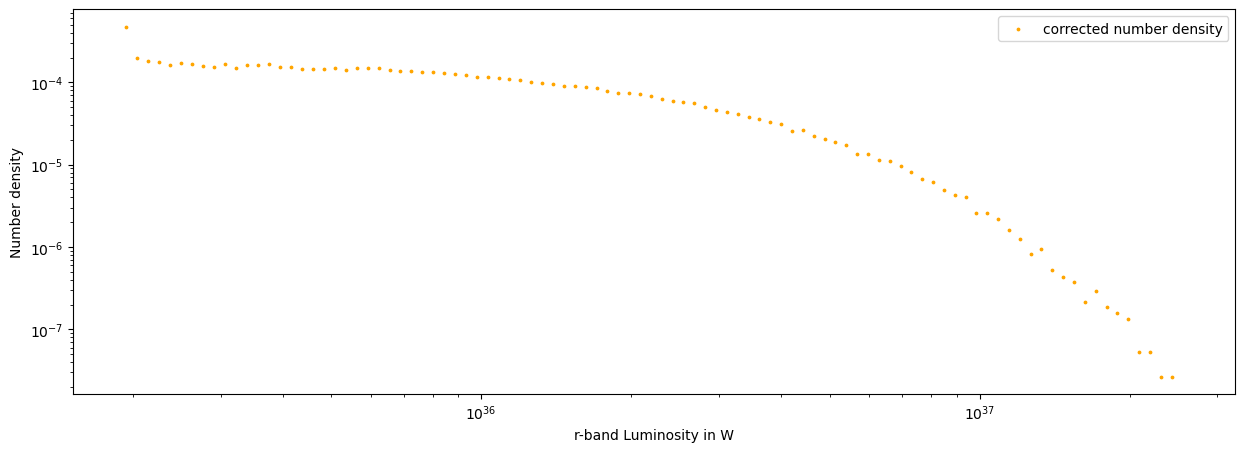

In [1375]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(center_lum_bins[1:], phi_j[1:], s = 3, color = "orange", label = "corrected number density")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")

plt.legend(loc = "upper right")
#plt.savefig("NumberDensity-1_overVmax.png", dpi = 300, transparent = True)

plt.show()

In [1376]:
def schechter_lum(L, phi_star, L_star, alpha):
    return phi_star*(L/L_star)**(alpha)*np.exp(-L/L_star)

In [1377]:
coefs_lum_fit, _ = curve_fit(schechter_lum, center_lum_bins[0:]/gs.L_sun_r, phi_j[0:], p0 = [30/(10**6), 2.5*10**8, -0.5])
print(coefs_lum_fit)

[ 1.68801504e-04  4.39770612e+08 -5.93472502e-02]


In [1378]:
"""fig, ax = plt.subplots(figsize = (15,5))

some_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), 1000, endpoint = True)


ax.plot(some_bins/gs.L_sun_r, schechter_lum(some_bins/gs.L_sun_r, 30/(10**6), 2.5*10**8, -0.5), linewidth = 2, alpha = 0.5, color = "orange", label = "some plot")
ax.scatter(center_lum_bins/gs.L_sun_r, phi_j, s = 3, color = "blue", label = "corrected number density, rescaled")
ax.plot(center_lum_bins/gs.L_sun_r, schechter_lum(center_lum_bins/gs.L_sun_r, *coefs_lum_fit), linewidth = 3, color = "green", label = "corrected number density, rescaled")

smodel = Model(schechter_lum)
result = smodel.fit(phi_j[0:], L = center_lum_bins[0:]/gs.L_sun_r, phi_star = 30/(10**6), L_star = 2.5*10**8, alpha = -0.5)
ax.plot(center_lum_bins/gs.L_sun_r, result.best_fit, "--", linewidth = 3, color = "red", label = "lmfit")
ax.plot(center_lum_bins/gs.L_sun_r, result.init_fit, "--", linewidth = 1, color = "black", label = "lmfit start")


ax.set_xscale("log")
ax.set_yscale("log")

#ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")
#ax.set_ylim(10**-8, 10**-3)
plt.legend(loc = "lower left")
#plt.savefig("NumberDensity-1_overVmax.png", dpi = 300, transparent = True)

plt.show()"""

'fig, ax = plt.subplots(figsize = (15,5))\n\nsome_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), 1000, endpoint = True)\n\n\nax.plot(some_bins/gs.L_sun_r, schechter_lum(some_bins/gs.L_sun_r, 30/(10**6), 2.5*10**8, -0.5), linewidth = 2, alpha = 0.5, color = "orange", label = "some plot")\nax.scatter(center_lum_bins/gs.L_sun_r, phi_j, s = 3, color = "blue", label = "corrected number density, rescaled")\nax.plot(center_lum_bins/gs.L_sun_r, schechter_lum(center_lum_bins/gs.L_sun_r, *coefs_lum_fit), linewidth = 3, color = "green", label = "corrected number density, rescaled")\n\nsmodel = Model(schechter_lum)\nresult = smodel.fit(phi_j[0:], L = center_lum_bins[0:]/gs.L_sun_r, phi_star = 30/(10**6), L_star = 2.5*10**8, alpha = -0.5)\nax.plot(center_lum_bins/gs.L_sun_r, result.best_fit, "--", linewidth = 3, color = "red", label = "lmfit")\nax.plot(center_lum_bins/gs.L_sun_r, result.init_fit, "--", linewidth = 1, color = "black", label = "lmfit start")\n\n\nax.set_xsca

In [1379]:
def calc_tot_num(lum_bins):
    
    tot_num = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(tot_num)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        
        tot_num[cnt] = len(dat)
        cnt += 1
    return tot_num

In [1380]:
"""fig, ax = plt.subplots(figsize = (15,5))

#tot_num = calc_tot_num(lum_bins)

ax.scatter(center_lum_bins[1:], phi_j[1:]*110000000, s = 3, color = "orange", label = "corrected number density")

#ax.scatter(center_lum_bins, tot_num, s = 3, label = "uncorrected number density")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")
plt.legend(loc = "lower left")
#plt.savefig("NumberDensity-total.png", dpi = 300, transparent = True)
plt.show()"""

'fig, ax = plt.subplots(figsize = (15,5))\n\n#tot_num = calc_tot_num(lum_bins)\n\nax.scatter(center_lum_bins[1:], phi_j[1:]*110000000, s = 3, color = "orange", label = "corrected number density")\n\n#ax.scatter(center_lum_bins, tot_num, s = 3, label = "uncorrected number density")\n\nax.set_xscale("log")\nax.set_yscale("log")\n\nax.set_xlabel("r-band Luminosity in W")\nax.set_ylabel("Number density")\nplt.legend(loc = "lower left")\n#plt.savefig("NumberDensity-total.png", dpi = 300, transparent = True)\nplt.show()'

In [1381]:
# Fit a schechter function to the data
# for this we need to go from the Luminosities back to the magnitudes...

In [1382]:
len(center_lum_bins), len(phi_j)

(99, 99)

In [1383]:
center_lum_bins, phi_j = np.array(center_lum_bins), np.array(phi_j)

In [1384]:
center_lum_bins.shape, phi_j.shape

((99,), (99,))

In [1385]:
center_lum_bins, phi_j

(array([1.83833625e+35, 1.93523039e+35, 2.03710046e+35, 2.14420197e+35,
        2.25680359e+35, 2.37518777e+35, 2.49965147e+35, 2.63050690e+35,
        2.76808229e+35, 2.91272275e+35, 3.06479110e+35, 3.22466879e+35,
        3.39275687e+35, 3.56947696e+35, 3.75527236e+35, 3.95060913e+35,
        4.15597724e+35, 4.37189187e+35, 4.59889460e+35, 4.83755487e+35,
        5.08847133e+35, 5.35227339e+35, 5.62962278e+35, 5.92121521e+35,
        6.22778213e+35, 6.55009252e+35, 6.88895489e+35, 7.24521925e+35,
        7.61977926e+35, 8.01357448e+35, 8.42759272e+35, 8.86287251e+35,
        9.32050572e+35, 9.80164029e+35, 1.03074831e+36, 1.08393031e+36,
        1.13984342e+36, 1.19862790e+36, 1.26043121e+36, 1.32540838e+36,
        1.39372239e+36, 1.46554461e+36, 1.54105520e+36, 1.62044357e+36,
        1.70390886e+36, 1.79166044e+36, 1.88391843e+36, 1.98091425e+36,
        2.08289121e+36, 2.19010510e+36, 2.30282488e+36, 2.42133328e+36,
        2.54592758e+36, 2.67692031e+36, 2.81464007e+36, 2.959432

In [1386]:
fit_data = hstack([Table({"LUM": center_lum_bins}), Table({"ABS_MAG_R": gs.M(center_lum_bins*u.W, band = "r")}), Table({"N": phi_j})])

In [1387]:
fit_data

LUM,ABS_MAG_R,N
,,
float64,float64,float64
1.8383362455113292e+35,-18.831477968401163,-6.86348359056771e-05
1.9352303928344023e+35,-18.887247283331238,0.00047470687297888566
2.037100456411345e+35,-18.942946708499885,0.00019632612862172555
2.144201970175349e+35,-18.998579820109896,0.00017950873083375738
2.2568035907866614e+35,-19.05415000368065,0.00017510515972884435
2.3751877715391057e+35,-19.109660464962527,0.00016216316197755642
2.4996514708742658e+35,-19.165114240154686,0.00017006670872278857
2.630506897281212e+35,-19.220514205477667,0.00016863021777423944


In [1388]:
fit_data = fit_data[fit_data["N"] != 0]

In [1389]:
fit_data[:55]

LUM,ABS_MAG_R,N
,,
float64,float64,float64
1.8383362455113292e+35,-18.831477968401163,-6.86348359056771e-05
1.9352303928344023e+35,-18.887247283331238,0.00047470687297888566
2.037100456411345e+35,-18.942946708499885,0.00019632612862172555
2.144201970175349e+35,-18.998579820109896,0.00017950873083375738
2.2568035907866614e+35,-19.05415000368065,0.00017510515972884435
2.3751877715391057e+35,-19.109660464962527,0.00016216316197755642
2.4996514708742658e+35,-19.165114240154686,0.00017006670872278857
2.630506897281212e+35,-19.220514205477667,0.00016863021777423944


In [1390]:
np.array(fit_data["N"])

array([-6.86348359e-05,  4.74706873e-04,  1.96326129e-04,  1.79508731e-04,
        1.75105160e-04,  1.62163162e-04,  1.70066709e-04,  1.68630218e-04,
        1.58233046e-04,  1.52288046e-04,  1.65640623e-04,  1.50945781e-04,
        1.60828512e-04,  1.64014577e-04,  1.66325460e-04,  1.54845495e-04,
        1.53765158e-04,  1.47002221e-04,  1.46413953e-04,  1.44438918e-04,
        1.49724484e-04,  1.42581552e-04,  1.51196361e-04,  1.50877594e-04,
        1.49018413e-04,  1.40788437e-04,  1.37411158e-04,  1.36462283e-04,
        1.32125079e-04,  1.32706795e-04,  1.28091477e-04,  1.24880069e-04,
        1.22460115e-04,  1.17293246e-04,  1.16787213e-04,  1.12499244e-04,
        1.09756010e-04,  1.05761008e-04,  1.01819273e-04,  9.91026723e-05,
        9.61463711e-05,  9.14322693e-05,  9.11659358e-05,  8.70377675e-05,
        8.48804667e-05,  7.87547976e-05,  7.45200960e-05,  7.39341624e-05,
        7.11376613e-05,  6.74622599e-05,  6.25084579e-05,  5.96853235e-05,
        5.69953557e-05,  

In [1391]:
# get model
Schechter = models.Schechter1D()
# set fitting algorithm
fit_alg = fitting.LMLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit

fit_lim = len(fit_data)-1

schechter_fit = fit_alg(Schechter, np.array(fit_data["ABS_MAG_R"][3:fit_lim]), np.array(fit_data["N"][3:fit_lim]))
#schechter_fit_scaled = fit_alg(Schechter, np.array(fit_data["ABS_MAG_R"][:fit_lim]), np.array(fit_data["N"][:fit_lim])*gs.omega_sky/area)


print(schechter_fit)
#print(schechter_fit_scaled)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           phi_star               m_star             alpha       
    ---------------------- ------------------- ------------------
    0.00019923351039687778 -21.526537428198218 -1.011080889270609


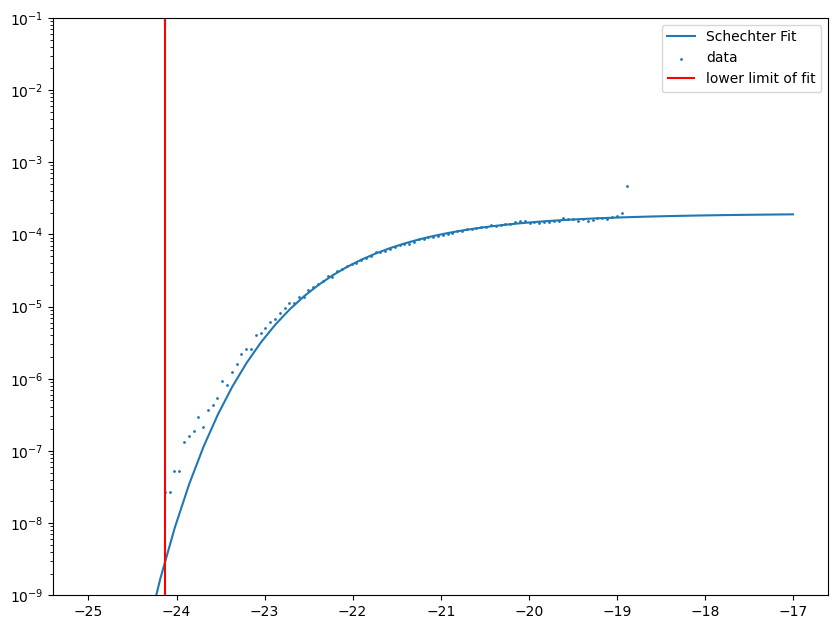

In [1392]:
fig, ax = plt.subplots(figsize = (10,7.5))

x = np.linspace(-25, -17)

ax.plot(x, schechter_fit(x), label = "Schechter Fit")
#ax.plot(x, schechter_fit_scaled(x), label = "Scaled Schechter Fit")
ax.scatter(np.array(fit_data["ABS_MAG_R"]), np.array(fit_data["N"]), label = "data", s = 1)
ax.vlines(fit_data["ABS_MAG_R"][fit_lim], 0,1, label = "lower limit of fit", color = "red")


ax.set_yscale('log')
ax.set_ylim(10**-9, 10**-1)
ax.legend()
plt.show()

In [1393]:
5*np.log10(0.7)

-0.7745097999287159

In [1394]:
np.max(np.array(fit_data["N"]))

0.00047470687297888566